In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay, cKDTree
from discretize import TensorMesh
import discretize.utils as utils

# Load models and mesh

In [67]:
input_dir = ['Main_NT', "Main_A", "Main_B", "Main_C", "Main_D"]

max_length = 5000

meshes, models, locs, weights, global_ind = [], [], [], [], []
for folder in input_dir:
    
    # Load the mesh
    mesh = TensorMesh.readUBC(folder + "\Mesh3D.msh")
#   

    # Reshape the model
    model = mesh.readModelUBC(folder + "\Inv_PCA_start.con")
    m = model.reshape(mesh.vnC, order='F')

    for ii in range(mesh.vnC[0]):
        for jj in range(mesh.vnC[1]):
            columnxy = m[ii, jj, :]
            ground = np.where(columnxy > 2e-8)[0]

            if len(ground)>0 and (ground[-1] != mesh.vnC[2]-1):

                columnxy[ground[-1]:]=columnxy[ground[-1]-1]


            m[ii, jj, :] = columnxy
    
    models.append(m)
    meshes.append(mesh)
    
    # Load the obs
    rxLoc = np.loadtxt(folder + "\Survey_A.loc")
    locs.append(rxLoc)
    
    
    # Get the unique xy points of the mesh
    tree_obs = cKDTree(rxLoc[:,:2])

#     mesh = meshes[-1]

    Y, X = np.meshgrid(mesh.vectorCCy, mesh.vectorCCx)
    # indx = tri.find_simplex(np.c_[X.ravel(),  Y.ravel()])

    r, ind = tree_obs.query(np.c_[X.ravel(),  Y.ravel()])

    ind_r = r<max_length
    
    
    w = np.zeros_like(r, dtype=float)
    w_tot = np.zeros_like(r, dtype=float)
    w[ind_r] = 1


    # Run a series of averaging on the neighbours
    tree = cKDTree(np.c_[X.ravel(),  Y.ravel()])

    _, ind = tree.query(np.c_[X.ravel(),  Y.ravel()], 9)
    old_max = 0
    while w.max()>old_max:

        old_max = w.max()
        w = np.min(w[ind], axis=1) + 1

        w[ind_r==False] = 0

    # Normalize to 1
    w /= w.max()

    # Convert to cosine tapper
    weights.append(-0.5*np.cos(-w*np.pi)+0.5)
    
    global_ind


In [68]:
# Create a global mesh
mesh_global = utils.mesh_builder_xyz(
    np.vstack(locs), np.r_[500,500,10], 
    depth_core=100, 
    padding_distance = [[500, 500], [500, 500], [1000, 0]],
    expansion_factor=1.2)

global_Y, global_X = np.meshgrid(mesh_global.vectorCCy, mesh_global.vectorCCx)


In [69]:
mInterp = np.zeros(mesh_global.vnC)
w_tot = np.zeros(mesh_global.vnC)

for mesh, model, w in zip(meshes, models, weights):
    Y, X = np.meshgrid(mesh.vectorCCy, mesh.vectorCCx)

    # Query the tile
    tree = cKDTree(np.c_[X.ravel(),  Y.ravel()])

    r, ind = tree.query(np.c_[global_X.ravel(),  global_Y.ravel()])

    # Run the interpolation
    for kk in range(mesh_global.vnC[2]):

        z_ind = np.searchsorted(mesh.vectorCCz, mesh_global.vectorCCz[kk]) - 1
        m2D = model[:, :, z_ind].ravel()

        mInterp[:, :, kk] += (m2D[ind] * w[ind]).reshape(global_X.shape)


        w_tot[:, :, kk] += w[ind].reshape(global_X.shape)


mInterp /= w_tot

mInterp[np.isnan(mInterp)] = 1e-8

C:\Users\DominiqueFournier\Anaconda3\Lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


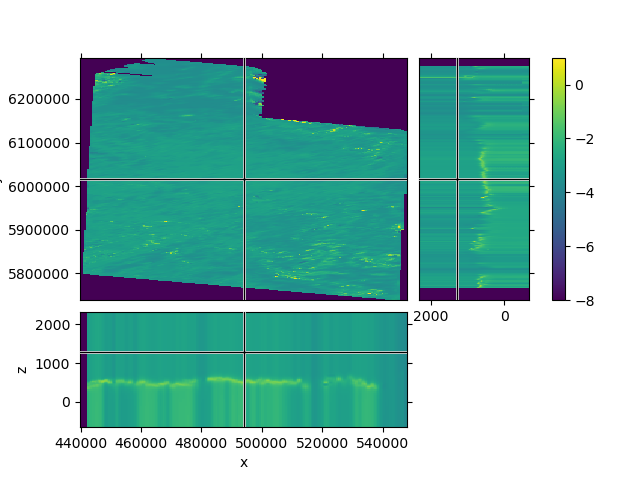

In [70]:
mesh_global.plot_3d_slicer(np.log10(mInterp.ravel(order='F')))





In [71]:
mesh_global.writeUBC("Global_500m.msh")


In [83]:
import xarray as xr
import dask.array as da
# # mesh_global.writeModelUBC("VTEM_global_500m.con", mInterp)
# xyz = xr.DataArray(
#     mInterp, 
#     dims=("x", "y", "z"), 
#     coords={
#         "x": mesh_global.vectorCCx, 
#         "y": mesh_global.vectorCCy, 
#         "z": mesh_global.vectorCCz
#     }
# )

# out = xr.Dataset(
#         data_vars={'con': xyz},
    
# )

# out.to_zarr(r".\VTEM_con_500m.zarr")
da.to_zarr(da.from_array(mInterp.ravel()), r".\VTEM_con_500m.zarr")



<IPython.core.display.Javascript object>


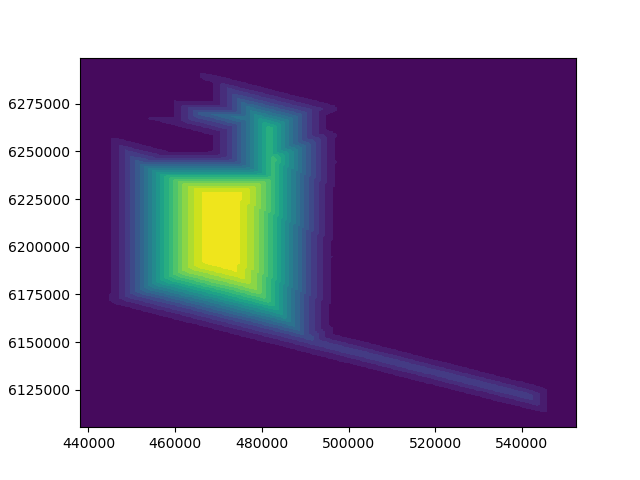

In [146]:
fig =plt.figure()
axs = plt.subplot()
axs.contourf(X, Y, w.reshape(X.shape),20)
# plt.triplot(locs[0][:,0], locs[0][:,1], tri.simplices)
plt.show()


In [30]:
X.shape


(379, 220)

In [122]:
mInterp = np.ones_like(m)
w_tot = np.zeros_like(m)
# Run the interpolation
for kk in range(meshes[0].vnC[2]):
    
    mInterp[:, :, kk] = m[:, :, kk] * w.reshape(X.shape)
    w_tot[:, :, kk] += w.reshape(X.shape)


mInterp /= w_tot
mInterp[np.isnan(mInterp)] = 1e-8



C:\Users\DominiqueFournier\Anaconda3\Lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


C:\Users\DominiqueFournier\Anaconda3\Lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


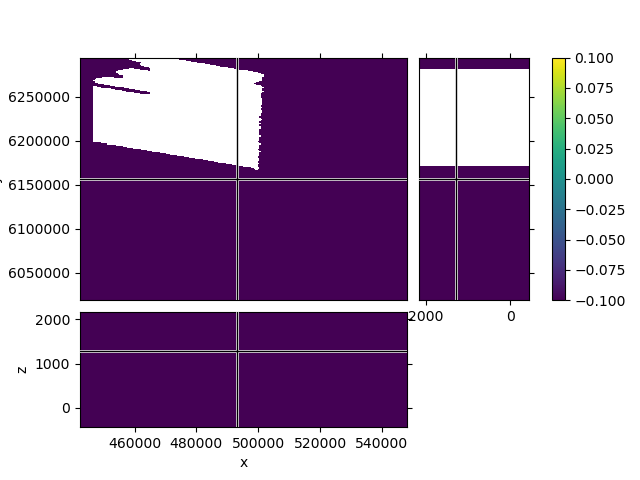

In [88]:
np.vstack(xy)


array([[ 547477.31409708, 5794274.87308513,       0.        ],
       [ 666614.9222899 , 5797363.64958792,       0.        ],
       [ 457908.64404805, 5955367.71197784,       0.        ],
       [ 574290.49666897, 5960254.33367672,       0.        ],
       [ 309297.84864233, 6229400.1190449 ,       0.        ],
       [ 475273.11185484, 6135320.71112711,       0.        ],
       [ 355748.43915618, 6241036.07245625,       0.        ]])